# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  1.526326 -0.353316  1.0  0.273724 -0.090974 -0.480601  1  1  13.324315   
1  0.062326 -0.329820  1.0  0.472726  0.259222 -1.511814  1  3  10.399319   
2  0.597068  1.224333  1.0  0.017555  0.348326  0.442411  2  1  14.487062   
3 -0.684090 -0.768397  1.0  0.234013 -1.713881  0.162241  2  0  15.102131   
4 -0.855385 -0.778343  1.0  0.045724  0.070478 -0.251896  0  2   9.305648   

            y  
0  165.492955  
1  106.592839  
2  220.962011  
3   99.797874  
4   65.451662  
True causal estimate is 8.926834366076124


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

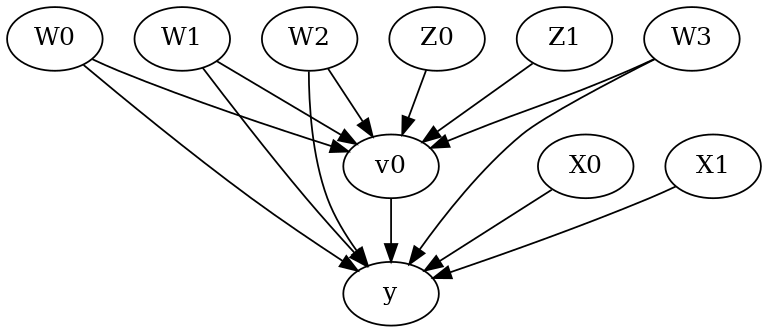

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W0+W3+W1+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 8.926966950005168



## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W0+W3+W1 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 12.243144454803245
Effect estimates: [[12.08004886]
 [13.83921456]
 [ 9.76529761]
 ...
 [10.22035054]
 [12.75189417]
 [ 9.95303719]]



In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 8.926834366076124


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W0+W3+W1 | X1,X0
Target units: 

## Estimate
Mean value: 8.887357470344705
Effect estimates: [[12.01983723]
 [ 9.19110868]
 [14.38807058]
 ...
 [10.1501797 ]
 [ 5.00127465]
 [ 8.16853551]]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W0+W3+W1 | X1,X0
Target units: ate

## Estimate
Mean value: 8.878892101677614
Effect estimates: [[12.01088099]
 [ 9.18270615]
 [14.34680877]
 ...
 [10.14000453]
 [ 5.0263113 ]
 [ 8.16023415]]
95.0% confidence interval: [[[12.07646945  9.24787858 14.41327777 ... 10.2072904   4.94193343
    8.18949693]]

 [[12.3470253   9.36540534 14.75600432 ... 10.36785744  5.18384866
    8.31565655]]]



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[[13.46217659]
 [11.25711795]
 [12.34491152]
 [12.19889176]
 [12.24795281]
 [14.07393547]
 [12.98914624]
 [11.52232161]
 [12.0280338 ]
 [12.43710352]]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     1.062596 -1.882353  1.0  0.507202  1.240562  0.170476 -1.756542   
1     0.166159  1.074704  1.0  0.199965 -1.562539 -0.265870 -1.164330   
2    -1.010085 -0.216742  1.0  0.944677 -0.800053 -1.769518 -1.134718   
3     0.304352  1.814707  1.0  0.755681 -0.365482 -1.000054 -0.068341   
4     0.522872 -0.299867  0.0  0.319517 -1.691802 -0.759917  1.642451   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.527932  0.908408  1.0  0.165713 -0.981157 -0.521445 -0.698637   
9996  0.110074  0.558190  0.0  0.920423 -0.049060 -1.217897 -1.357007   
9997  2.437218 -0.183723  0.0  0.570056 -0.688336 -1.181400  0.450143   
9998 -0.632778  0.491221  1.0  0.862875  2.503631 -0.212506  0.102661   
9999  0.774836  1.019736  1.0  0.211709 -1.400184 -0.651707 -1.490507   

            W3  v0  y  
0     0.145233   1  0  
1     1.177331   1  1  
2    -0.478393   1  0  
3    -0.749313   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.dr.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W0+W3+W1 | X1,X0
Target units: ate

## Estimate
Mean value: 0.5333527681080347
Effect estimates: [[0.28322726]
 [0.68419065]
 [0.29365225]
 ...
 [0.77319875]
 [0.47098541]
 [0.75808588]]

True causal estimate is 0.4961


### Instrumental Variable Method

In [16]:
import keras
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.iv.nnet.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2023-03-07 16:47:52.026035: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-03-07 16:47:52.184930: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 16:47:52.184968: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-03-07 16:47:53.035861: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-07 16:47:53.036027: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-07 16:47:53.036042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2023-03-07 16:47:53.977053: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-07 16:47:53.977092: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 16:47:53.977119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (65988a3930fb): /proc/driver/nvidia/version does not exist
2023-03-07 16:47:53.977708: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 6:21 - loss: 62.5386

 27/313 [=>............................] - ETA: 0s - loss: 34.4128  

 56/313 [====>.........................] - ETA: 0s - loss: 19.0774

 85/313 [=======>......................] - ETA: 0s - loss: 13.9078

114/313 [=========>....................] - ETA: 0s - loss: 11.3152

143/313 [============>.................] - ETA: 0s - loss: 9.7606 

169/313 [===============>..............] - ETA: 0s - loss: 8.8150

197/313 [=================>............] - ETA: 0s - loss: 8.0584

225/313 [====================>.........] - ETA: 0s - loss: 7.4806

253/313 [=======================>......] - ETA: 0s - loss: 7.0226

281/313 [=========================>....] - ETA: 0s - loss: 6.6478

309/313 [============================>.] - ETA: 0s - loss: 6.3282

313/313 [==============================] - 2s 2ms/step - loss: 6.2872


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 3.2936

 28/313 [=>............................] - ETA: 0s - loss: 2.9604

 55/313 [====>.........................] - ETA: 0s - loss: 2.9013

 82/313 [======>.......................] - ETA: 0s - loss: 2.8162

110/313 [=========>....................] - ETA: 0s - loss: 2.7566

138/313 [============>.................] - ETA: 0s - loss: 2.7080

165/313 [==============>...............] - ETA: 0s - loss: 2.6690

194/313 [=================>............] - ETA: 0s - loss: 2.6401

223/313 [====================>.........] - ETA: 0s - loss: 2.6142

251/313 [=======================>......] - ETA: 0s - loss: 2.5949

279/313 [=========================>....] - ETA: 0s - loss: 2.5728

306/313 [============================>.] - ETA: 0s - loss: 2.5507

313/313 [==============================] - 1s 2ms/step - loss: 2.5467


Epoch 3/25


  1/313 [..............................] - ETA: 0s - loss: 2.1433

 31/313 [=>............................] - ETA: 0s - loss: 2.3382

 60/313 [====>.........................] - ETA: 0s - loss: 2.3316

 89/313 [=======>......................] - ETA: 0s - loss: 2.3280

117/313 [==========>...................] - ETA: 0s - loss: 2.3122

145/313 [============>.................] - ETA: 0s - loss: 2.3150

174/313 [===============>..............] - ETA: 0s - loss: 2.3176

203/313 [==================>...........] - ETA: 0s - loss: 2.3167

232/313 [=====================>........] - ETA: 0s - loss: 2.3171

260/313 [=======================>......] - ETA: 0s - loss: 2.3088

287/313 [==========================>...] - ETA: 0s - loss: 2.3033

313/313 [==============================] - 1s 2ms/step - loss: 2.3035


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 2.4772

 30/313 [=>............................] - ETA: 0s - loss: 2.2417

 58/313 [====>.........................] - ETA: 0s - loss: 2.2524

 86/313 [=======>......................] - ETA: 0s - loss: 2.2528

114/313 [=========>....................] - ETA: 0s - loss: 2.2515

143/313 [============>.................] - ETA: 0s - loss: 2.2482

173/313 [===============>..............] - ETA: 0s - loss: 2.2518

201/313 [==================>...........] - ETA: 0s - loss: 2.2574

229/313 [====================>.........] - ETA: 0s - loss: 2.2601

258/313 [=======================>......] - ETA: 0s - loss: 2.2625

286/313 [==========================>...] - ETA: 0s - loss: 2.2585

313/313 [==============================] - 1s 2ms/step - loss: 2.2626


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 2.0698

 31/313 [=>............................] - ETA: 0s - loss: 2.2860

 60/313 [====>.........................] - ETA: 0s - loss: 2.2427

 89/313 [=======>......................] - ETA: 0s - loss: 2.2409

118/313 [==========>...................] - ETA: 0s - loss: 2.2242

147/313 [=============>................] - ETA: 0s - loss: 2.2238

176/313 [===============>..............] - ETA: 0s - loss: 2.2210

205/313 [==================>...........] - ETA: 0s - loss: 2.2220

232/313 [=====================>........] - ETA: 0s - loss: 2.2183

258/313 [=======================>......] - ETA: 0s - loss: 2.2169

287/313 [==========================>...] - ETA: 0s - loss: 2.2200

313/313 [==============================] - 1s 2ms/step - loss: 2.2196


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 2.2405

 28/313 [=>............................] - ETA: 0s - loss: 2.2324

 55/313 [====>.........................] - ETA: 0s - loss: 2.2331

 85/313 [=======>......................] - ETA: 0s - loss: 2.2237

112/313 [=========>....................] - ETA: 0s - loss: 2.2192

140/313 [============>.................] - ETA: 0s - loss: 2.2151

168/313 [===============>..............] - ETA: 0s - loss: 2.2127

197/313 [=================>............] - ETA: 0s - loss: 2.2071

225/313 [====================>.........] - ETA: 0s - loss: 2.2103

252/313 [=======================>......] - ETA: 0s - loss: 2.2095

282/313 [==========================>...] - ETA: 0s - loss: 2.2076

309/313 [============================>.] - ETA: 0s - loss: 2.2089

313/313 [==============================] - 1s 2ms/step - loss: 2.2090


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 2.2165

 31/313 [=>............................] - ETA: 0s - loss: 2.2050

 59/313 [====>.........................] - ETA: 0s - loss: 2.1756

 87/313 [=======>......................] - ETA: 0s - loss: 2.1789

114/313 [=========>....................] - ETA: 0s - loss: 2.1734

143/313 [============>.................] - ETA: 0s - loss: 2.1678

170/313 [===============>..............] - ETA: 0s - loss: 2.1791

199/313 [==================>...........] - ETA: 0s - loss: 2.1753

227/313 [====================>.........] - ETA: 0s - loss: 2.1823

255/313 [=======================>......] - ETA: 0s - loss: 2.1816

283/313 [==========================>...] - ETA: 0s - loss: 2.1818

311/313 [============================>.] - ETA: 0s - loss: 2.1814

313/313 [==============================] - 1s 2ms/step - loss: 2.1819


Epoch 8/25


  1/313 [..............................] - ETA: 0s - loss: 1.9018

 30/313 [=>............................] - ETA: 0s - loss: 2.1434

 58/313 [====>.........................] - ETA: 0s - loss: 2.1310

 85/313 [=======>......................] - ETA: 0s - loss: 2.1407

114/313 [=========>....................] - ETA: 0s - loss: 2.1594

143/313 [============>.................] - ETA: 0s - loss: 2.1572

170/313 [===============>..............] - ETA: 0s - loss: 2.1650

199/313 [==================>...........] - ETA: 0s - loss: 2.1722

226/313 [====================>.........] - ETA: 0s - loss: 2.1750

255/313 [=======================>......] - ETA: 0s - loss: 2.1774

283/313 [==========================>...] - ETA: 0s - loss: 2.1751

312/313 [============================>.] - ETA: 0s - loss: 2.1738

313/313 [==============================] - 1s 2ms/step - loss: 2.1731


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.0574

 29/313 [=>............................] - ETA: 0s - loss: 2.1743

 58/313 [====>.........................] - ETA: 0s - loss: 2.1448

 87/313 [=======>......................] - ETA: 0s - loss: 2.1494

116/313 [==========>...................] - ETA: 0s - loss: 2.1675

144/313 [============>.................] - ETA: 0s - loss: 2.1671

172/313 [===============>..............] - ETA: 0s - loss: 2.1647

200/313 [==================>...........] - ETA: 0s - loss: 2.1715

226/313 [====================>.........] - ETA: 0s - loss: 2.1750

254/313 [=======================>......] - ETA: 0s - loss: 2.1779

283/313 [==========================>...] - ETA: 0s - loss: 2.1726

312/313 [============================>.] - ETA: 0s - loss: 2.1699

313/313 [==============================] - 1s 2ms/step - loss: 2.1707


Epoch 10/25


  1/313 [..............................] - ETA: 0s - loss: 2.0895

 31/313 [=>............................] - ETA: 0s - loss: 2.1708

 59/313 [====>.........................] - ETA: 0s - loss: 2.1486

 87/313 [=======>......................] - ETA: 0s - loss: 2.1435

114/313 [=========>....................] - ETA: 0s - loss: 2.1399

142/313 [============>.................] - ETA: 0s - loss: 2.1359

170/313 [===============>..............] - ETA: 0s - loss: 2.1393

199/313 [==================>...........] - ETA: 0s - loss: 2.1441

227/313 [====================>.........] - ETA: 0s - loss: 2.1431

255/313 [=======================>......] - ETA: 0s - loss: 2.1484

283/313 [==========================>...] - ETA: 0s - loss: 2.1497

310/313 [============================>.] - ETA: 0s - loss: 2.1468

313/313 [==============================] - 1s 2ms/step - loss: 2.1457


Epoch 11/25


  1/313 [..............................] - ETA: 0s - loss: 2.1145

 28/313 [=>............................] - ETA: 0s - loss: 2.1447

 57/313 [====>.........................] - ETA: 0s - loss: 2.1226

 83/313 [======>.......................] - ETA: 0s - loss: 2.1383

110/313 [=========>....................] - ETA: 0s - loss: 2.1436

138/313 [============>.................] - ETA: 0s - loss: 2.1456

166/313 [==============>...............] - ETA: 0s - loss: 2.1378

194/313 [=================>............] - ETA: 0s - loss: 2.1448

223/313 [====================>.........] - ETA: 0s - loss: 2.1414

253/313 [=======================>......] - ETA: 0s - loss: 2.1462

282/313 [==========================>...] - ETA: 0s - loss: 2.1450

311/313 [============================>.] - ETA: 0s - loss: 2.1451

313/313 [==============================] - 1s 2ms/step - loss: 2.1457


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 2.0234

 29/313 [=>............................] - ETA: 0s - loss: 2.1152

 53/313 [====>.........................] - ETA: 0s - loss: 2.1061

 76/313 [======>.......................] - ETA: 0s - loss: 2.1150

104/313 [========>.....................] - ETA: 0s - loss: 2.1178

132/313 [===========>..................] - ETA: 0s - loss: 2.1232

161/313 [==============>...............] - ETA: 0s - loss: 2.1247

187/313 [================>.............] - ETA: 0s - loss: 2.1255

215/313 [===================>..........] - ETA: 0s - loss: 2.1227

243/313 [======================>.......] - ETA: 0s - loss: 2.1211

271/313 [========================>.....] - ETA: 0s - loss: 2.1193

299/313 [===========================>..] - ETA: 0s - loss: 2.1250

313/313 [==============================] - 1s 2ms/step - loss: 2.1240


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2.1337

 30/313 [=>............................] - ETA: 0s - loss: 2.1878

 58/313 [====>.........................] - ETA: 0s - loss: 2.1518

 87/313 [=======>......................] - ETA: 0s - loss: 2.1538

116/313 [==========>...................] - ETA: 0s - loss: 2.1399

145/313 [============>.................] - ETA: 0s - loss: 2.1414

173/313 [===============>..............] - ETA: 0s - loss: 2.1400

202/313 [==================>...........] - ETA: 0s - loss: 2.1385

229/313 [====================>.........] - ETA: 0s - loss: 2.1391

257/313 [=======================>......] - ETA: 0s - loss: 2.1358

286/313 [==========================>...] - ETA: 0s - loss: 2.1344

313/313 [==============================] - 1s 2ms/step - loss: 2.1341


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.0329

 30/313 [=>............................] - ETA: 0s - loss: 2.0966

 59/313 [====>.........................] - ETA: 0s - loss: 2.1278

 86/313 [=======>......................] - ETA: 0s - loss: 2.1241

114/313 [=========>....................] - ETA: 0s - loss: 2.1258

143/313 [============>.................] - ETA: 0s - loss: 2.1209

172/313 [===============>..............] - ETA: 0s - loss: 2.1189

202/313 [==================>...........] - ETA: 0s - loss: 2.1179

232/313 [=====================>........] - ETA: 0s - loss: 2.1175

260/313 [=======================>......] - ETA: 0s - loss: 2.1175

289/313 [==========================>...] - ETA: 0s - loss: 2.1163

313/313 [==============================] - 1s 2ms/step - loss: 2.1184


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 2.2753

 31/313 [=>............................] - ETA: 0s - loss: 2.1486

 59/313 [====>.........................] - ETA: 0s - loss: 2.1145

 87/313 [=======>......................] - ETA: 0s - loss: 2.1220

115/313 [==========>...................] - ETA: 0s - loss: 2.1274

143/313 [============>.................] - ETA: 0s - loss: 2.1267

171/313 [===============>..............] - ETA: 0s - loss: 2.1249

200/313 [==================>...........] - ETA: 0s - loss: 2.1239

229/313 [====================>.........] - ETA: 0s - loss: 2.1173

257/313 [=======================>......] - ETA: 0s - loss: 2.1166

285/313 [==========================>...] - ETA: 0s - loss: 2.1100

313/313 [==============================] - 1s 2ms/step - loss: 2.1085


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 1.9207

 29/313 [=>............................] - ETA: 0s - loss: 2.0897

 58/313 [====>.........................] - ETA: 0s - loss: 2.0989

 87/313 [=======>......................] - ETA: 0s - loss: 2.1050

114/313 [=========>....................] - ETA: 0s - loss: 2.1036

142/313 [============>.................] - ETA: 0s - loss: 2.1001

171/313 [===============>..............] - ETA: 0s - loss: 2.1040

200/313 [==================>...........] - ETA: 0s - loss: 2.0959

229/313 [====================>.........] - ETA: 0s - loss: 2.0954

258/313 [=======================>......] - ETA: 0s - loss: 2.0965

286/313 [==========================>...] - ETA: 0s - loss: 2.0959

313/313 [==============================] - ETA: 0s - loss: 2.1008

313/313 [==============================] - 1s 2ms/step - loss: 2.1008


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.1338

 30/313 [=>............................] - ETA: 0s - loss: 2.1106

 56/313 [====>.........................] - ETA: 0s - loss: 2.0971

 84/313 [=======>......................] - ETA: 0s - loss: 2.0982

113/313 [=========>....................] - ETA: 0s - loss: 2.0965

142/313 [============>.................] - ETA: 0s - loss: 2.0992

169/313 [===============>..............] - ETA: 0s - loss: 2.0997

197/313 [=================>............] - ETA: 0s - loss: 2.1054

225/313 [====================>.........] - ETA: 0s - loss: 2.1014

254/313 [=======================>......] - ETA: 0s - loss: 2.0994

283/313 [==========================>...] - ETA: 0s - loss: 2.0965

311/313 [============================>.] - ETA: 0s - loss: 2.0983

313/313 [==============================] - 1s 2ms/step - loss: 2.0972


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 1.8020

 29/313 [=>............................] - ETA: 0s - loss: 2.0699

 56/313 [====>.........................] - ETA: 0s - loss: 2.0822

 85/313 [=======>......................] - ETA: 0s - loss: 2.0934

112/313 [=========>....................] - ETA: 0s - loss: 2.0916

140/313 [============>.................] - ETA: 0s - loss: 2.0935

169/313 [===============>..............] - ETA: 0s - loss: 2.0890

197/313 [=================>............] - ETA: 0s - loss: 2.0913

226/313 [====================>.........] - ETA: 0s - loss: 2.0925

254/313 [=======================>......] - ETA: 0s - loss: 2.0944

283/313 [==========================>...] - ETA: 0s - loss: 2.0913

311/313 [============================>.] - ETA: 0s - loss: 2.0894

313/313 [==============================] - 1s 2ms/step - loss: 2.0891


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 2.3570

 31/313 [=>............................] - ETA: 0s - loss: 2.0968

 58/313 [====>.........................] - ETA: 0s - loss: 2.0814

 87/313 [=======>......................] - ETA: 0s - loss: 2.0865

115/313 [==========>...................] - ETA: 0s - loss: 2.0786

144/313 [============>.................] - ETA: 0s - loss: 2.0749

172/313 [===============>..............] - ETA: 0s - loss: 2.0748

197/313 [=================>............] - ETA: 0s - loss: 2.0751

225/313 [====================>.........] - ETA: 0s - loss: 2.0778

253/313 [=======================>......] - ETA: 0s - loss: 2.0831

281/313 [=========================>....] - ETA: 0s - loss: 2.0875

309/313 [============================>.] - ETA: 0s - loss: 2.0893

313/313 [==============================] - 1s 2ms/step - loss: 2.0898


Epoch 20/25


  1/313 [..............................] - ETA: 0s - loss: 2.0187

 27/313 [=>............................] - ETA: 0s - loss: 2.0699

 56/313 [====>.........................] - ETA: 0s - loss: 2.0771

 84/313 [=======>......................] - ETA: 0s - loss: 2.0808

112/313 [=========>....................] - ETA: 0s - loss: 2.0803

140/313 [============>.................] - ETA: 0s - loss: 2.0789

169/313 [===============>..............] - ETA: 0s - loss: 2.0802

196/313 [=================>............] - ETA: 0s - loss: 2.0774

224/313 [====================>.........] - ETA: 0s - loss: 2.0827

252/313 [=======================>......] - ETA: 0s - loss: 2.0885

279/313 [=========================>....] - ETA: 0s - loss: 2.0838

306/313 [============================>.] - ETA: 0s - loss: 2.0833

313/313 [==============================] - 1s 2ms/step - loss: 2.0835


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 2.0661

 31/313 [=>............................] - ETA: 0s - loss: 2.0770

 61/313 [====>.........................] - ETA: 0s - loss: 2.0729

 89/313 [=======>......................] - ETA: 0s - loss: 2.0742

116/313 [==========>...................] - ETA: 0s - loss: 2.0697

144/313 [============>.................] - ETA: 0s - loss: 2.0672

171/313 [===============>..............] - ETA: 0s - loss: 2.0743

200/313 [==================>...........] - ETA: 0s - loss: 2.0699

228/313 [====================>.........] - ETA: 0s - loss: 2.0727

257/313 [=======================>......] - ETA: 0s - loss: 2.0707

283/313 [==========================>...] - ETA: 0s - loss: 2.0738

313/313 [==============================] - ETA: 0s - loss: 2.0731

313/313 [==============================] - 1s 2ms/step - loss: 2.0731


Epoch 22/25


  1/313 [..............................] - ETA: 0s - loss: 2.1604

 31/313 [=>............................] - ETA: 0s - loss: 2.0433

 60/313 [====>.........................] - ETA: 0s - loss: 2.0447

 89/313 [=======>......................] - ETA: 0s - loss: 2.0550

119/313 [==========>...................] - ETA: 0s - loss: 2.0589

148/313 [=============>................] - ETA: 0s - loss: 2.0625

177/313 [===============>..............] - ETA: 0s - loss: 2.0694

207/313 [==================>...........] - ETA: 0s - loss: 2.0753

236/313 [=====================>........] - ETA: 0s - loss: 2.0746

265/313 [========================>.....] - ETA: 0s - loss: 2.0753

294/313 [===========================>..] - ETA: 0s - loss: 2.0777

313/313 [==============================] - 1s 2ms/step - loss: 2.0764


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 2.0011

 31/313 [=>............................] - ETA: 0s - loss: 2.0467

 60/313 [====>.........................] - ETA: 0s - loss: 2.0732

 88/313 [=======>......................] - ETA: 0s - loss: 2.0756

117/313 [==========>...................] - ETA: 0s - loss: 2.0662

146/313 [============>.................] - ETA: 0s - loss: 2.0716

175/313 [===============>..............] - ETA: 0s - loss: 2.0641

204/313 [==================>...........] - ETA: 0s - loss: 2.0630

234/313 [=====================>........] - ETA: 0s - loss: 2.0644

260/313 [=======================>......] - ETA: 0s - loss: 2.0680

288/313 [==========================>...] - ETA: 0s - loss: 2.0679

313/313 [==============================] - 1s 2ms/step - loss: 2.0697


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 2.0197

 30/313 [=>............................] - ETA: 0s - loss: 2.0625

 58/313 [====>.........................] - ETA: 0s - loss: 2.0588

 87/313 [=======>......................] - ETA: 0s - loss: 2.0606

115/313 [==========>...................] - ETA: 0s - loss: 2.0634

144/313 [============>.................] - ETA: 0s - loss: 2.0681

172/313 [===============>..............] - ETA: 0s - loss: 2.0705

200/313 [==================>...........] - ETA: 0s - loss: 2.0715

228/313 [====================>.........] - ETA: 0s - loss: 2.0716

257/313 [=======================>......] - ETA: 0s - loss: 2.0706

285/313 [==========================>...] - ETA: 0s - loss: 2.0700

309/313 [============================>.] - ETA: 0s - loss: 2.0704

313/313 [==============================] - 1s 2ms/step - loss: 2.0707


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 2.0108

 30/313 [=>............................] - ETA: 0s - loss: 2.0877

 58/313 [====>.........................] - ETA: 0s - loss: 2.0635

 87/313 [=======>......................] - ETA: 0s - loss: 2.0621

115/313 [==========>...................] - ETA: 0s - loss: 2.0643

143/313 [============>.................] - ETA: 0s - loss: 2.0631

172/313 [===============>..............] - ETA: 0s - loss: 2.0556

200/313 [==================>...........] - ETA: 0s - loss: 2.0594

228/313 [====================>.........] - ETA: 0s - loss: 2.0602

256/313 [=======================>......] - ETA: 0s - loss: 2.0602

284/313 [==========================>...] - ETA: 0s - loss: 2.0601

312/313 [============================>.] - ETA: 0s - loss: 2.0619

313/313 [==============================] - 1s 2ms/step - loss: 2.0619


Epoch 1/25


  1/313 [..............................] - ETA: 8:59 - loss: 30450.4844

 24/313 [=>............................] - ETA: 0s - loss: 27199.7969  

 46/313 [===>..........................] - ETA: 0s - loss: 22866.6875

 70/313 [=====>........................] - ETA: 0s - loss: 18361.7188

 93/313 [=======>......................] - ETA: 0s - loss: 15809.4453

117/313 [==========>...................] - ETA: 0s - loss: 14096.1211

142/313 [============>.................] - ETA: 0s - loss: 12823.5576

164/313 [==============>...............] - ETA: 0s - loss: 12060.9854

188/313 [=================>............] - ETA: 0s - loss: 11403.2344

211/313 [===================>..........] - ETA: 0s - loss: 10828.5430

234/313 [=====================>........] - ETA: 0s - loss: 10350.7178

259/313 [=======================>......] - ETA: 0s - loss: 9853.6289 

283/313 [==========================>...] - ETA: 0s - loss: 9438.8516

307/313 [============================>.] - ETA: 0s - loss: 9093.2461

313/313 [==============================] - 2s 2ms/step - loss: 8991.9404


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 7025.9600

 22/313 [=>............................] - ETA: 0s - loss: 4804.0737

 46/313 [===>..........................] - ETA: 0s - loss: 4536.2236

 69/313 [=====>........................] - ETA: 0s - loss: 4483.6372

 93/313 [=======>......................] - ETA: 0s - loss: 4506.4497

117/313 [==========>...................] - ETA: 0s - loss: 4520.4097

141/313 [============>.................] - ETA: 0s - loss: 4413.2900

164/313 [==============>...............] - ETA: 0s - loss: 4371.0645

188/313 [=================>............] - ETA: 0s - loss: 4285.7520

212/313 [===================>..........] - ETA: 0s - loss: 4265.4761

235/313 [=====================>........] - ETA: 0s - loss: 4234.0029

259/313 [=======================>......] - ETA: 0s - loss: 4201.4912

283/313 [==========================>...] - ETA: 0s - loss: 4169.9536

306/313 [============================>.] - ETA: 0s - loss: 4139.6489

313/313 [==============================] - 1s 2ms/step - loss: 4138.5376


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 4746.4180

 24/313 [=>............................] - ETA: 0s - loss: 3883.8955

 47/313 [===>..........................] - ETA: 0s - loss: 3903.1287

 71/313 [=====>........................] - ETA: 0s - loss: 3865.0291

 94/313 [========>.....................] - ETA: 0s - loss: 3849.8064

118/313 [==========>...................] - ETA: 0s - loss: 3828.8000

142/313 [============>.................] - ETA: 0s - loss: 3886.8782

166/313 [==============>...............] - ETA: 0s - loss: 3937.3403

190/313 [=================>............] - ETA: 0s - loss: 3967.5256

213/313 [===================>..........] - ETA: 0s - loss: 3932.1843

236/313 [=====================>........] - ETA: 0s - loss: 3910.3367

258/313 [=======================>......] - ETA: 0s - loss: 3907.7803

278/313 [=========================>....] - ETA: 0s - loss: 3870.3472

302/313 [===========================>..] - ETA: 0s - loss: 3840.9565

313/313 [==============================] - 1s 2ms/step - loss: 3841.9390


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 3806.0310

 24/313 [=>............................] - ETA: 0s - loss: 3819.2441

 45/313 [===>..........................] - ETA: 0s - loss: 3689.6506

 68/313 [=====>........................] - ETA: 0s - loss: 3581.1782

 91/313 [=======>......................] - ETA: 0s - loss: 3590.1992

114/313 [=========>....................] - ETA: 0s - loss: 3513.3586

137/313 [============>.................] - ETA: 0s - loss: 3522.2253

158/313 [==============>...............] - ETA: 0s - loss: 3632.5767

178/313 [================>.............] - ETA: 0s - loss: 3661.5085

202/313 [==================>...........] - ETA: 0s - loss: 3652.9326

226/313 [====================>.........] - ETA: 0s - loss: 3716.0730

250/313 [======================>.......] - ETA: 0s - loss: 3705.8093

274/313 [=========================>....] - ETA: 0s - loss: 3729.0156

298/313 [===========================>..] - ETA: 0s - loss: 3746.3237

313/313 [==============================] - 1s 2ms/step - loss: 3744.2910


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 3370.9099

 26/313 [=>............................] - ETA: 0s - loss: 3338.3967

 46/313 [===>..........................] - ETA: 0s - loss: 3509.2986

 70/313 [=====>........................] - ETA: 0s - loss: 3591.0496

 93/313 [=======>......................] - ETA: 0s - loss: 3598.5149

116/313 [==========>...................] - ETA: 0s - loss: 3566.7048

140/313 [============>.................] - ETA: 0s - loss: 3604.0916

164/313 [==============>...............] - ETA: 0s - loss: 3645.6689

187/313 [================>.............] - ETA: 0s - loss: 3667.7651

211/313 [===================>..........] - ETA: 0s - loss: 3662.2283

235/313 [=====================>........] - ETA: 0s - loss: 3644.3713

258/313 [=======================>......] - ETA: 0s - loss: 3666.5869

281/313 [=========================>....] - ETA: 0s - loss: 3670.9802

304/313 [============================>.] - ETA: 0s - loss: 3690.3438

313/313 [==============================] - 1s 2ms/step - loss: 3694.4019


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 3429.5181

 25/313 [=>............................] - ETA: 0s - loss: 3577.8538

 46/313 [===>..........................] - ETA: 0s - loss: 3564.5349

 70/313 [=====>........................] - ETA: 0s - loss: 3583.5188

 93/313 [=======>......................] - ETA: 0s - loss: 3561.6436

116/313 [==========>...................] - ETA: 0s - loss: 3634.5256

140/313 [============>.................] - ETA: 0s - loss: 3603.2251

163/313 [==============>...............] - ETA: 0s - loss: 3617.4478

184/313 [================>.............] - ETA: 0s - loss: 3642.6250

206/313 [==================>...........] - ETA: 0s - loss: 3648.4185

227/313 [====================>.........] - ETA: 0s - loss: 3691.4045

249/313 [======================>.......] - ETA: 0s - loss: 3663.7478

270/313 [========================>.....] - ETA: 0s - loss: 3659.1589

292/313 [==========================>...] - ETA: 0s - loss: 3653.3989

313/313 [==============================] - ETA: 0s - loss: 3668.7947

313/313 [==============================] - 1s 2ms/step - loss: 3668.7947


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 2326.6621

 22/313 [=>............................] - ETA: 0s - loss: 3152.9412

 45/313 [===>..........................] - ETA: 0s - loss: 3449.8242

 69/313 [=====>........................] - ETA: 0s - loss: 3491.8071

 93/313 [=======>......................] - ETA: 0s - loss: 3559.7651

115/313 [==========>...................] - ETA: 0s - loss: 3662.4980

135/313 [===========>..................] - ETA: 0s - loss: 3603.0332

156/313 [=============>................] - ETA: 0s - loss: 3553.5496

179/313 [================>.............] - ETA: 0s - loss: 3554.8223

202/313 [==================>...........] - ETA: 0s - loss: 3571.1570

226/313 [====================>.........] - ETA: 0s - loss: 3584.1001

250/313 [======================>.......] - ETA: 0s - loss: 3588.8755

274/313 [=========================>....] - ETA: 0s - loss: 3596.7322

298/313 [===========================>..] - ETA: 0s - loss: 3627.2207

313/313 [==============================] - 1s 2ms/step - loss: 3611.0520


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2516.0151

 26/313 [=>............................] - ETA: 0s - loss: 3589.6545

 49/313 [===>..........................] - ETA: 0s - loss: 3603.5784

 72/313 [=====>........................] - ETA: 0s - loss: 3635.2256

 95/313 [========>.....................] - ETA: 0s - loss: 3672.4868

119/313 [==========>...................] - ETA: 0s - loss: 3583.5454

143/313 [============>.................] - ETA: 0s - loss: 3528.9290

166/313 [==============>...............] - ETA: 0s - loss: 3605.0283

189/313 [=================>............] - ETA: 0s - loss: 3591.1074

211/313 [===================>..........] - ETA: 0s - loss: 3606.1304

234/313 [=====================>........] - ETA: 0s - loss: 3573.7454

254/313 [=======================>......] - ETA: 0s - loss: 3598.7346

275/313 [=========================>....] - ETA: 0s - loss: 3608.4006

296/313 [===========================>..] - ETA: 0s - loss: 3600.4966

313/313 [==============================] - 1s 2ms/step - loss: 3607.8418


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 4591.5889

 24/313 [=>............................] - ETA: 0s - loss: 3621.4141

 45/313 [===>..........................] - ETA: 0s - loss: 3548.6729

 69/313 [=====>........................] - ETA: 0s - loss: 3609.1223

 93/313 [=======>......................] - ETA: 0s - loss: 3611.3420

117/313 [==========>...................] - ETA: 0s - loss: 3623.5706

141/313 [============>.................] - ETA: 0s - loss: 3734.4500

161/313 [==============>...............] - ETA: 0s - loss: 3730.0659

183/313 [================>.............] - ETA: 0s - loss: 3709.0564

204/313 [==================>...........] - ETA: 0s - loss: 3717.2119

225/313 [====================>.........] - ETA: 0s - loss: 3700.6978

247/313 [======================>.......] - ETA: 0s - loss: 3730.1094

269/313 [========================>.....] - ETA: 0s - loss: 3706.4370

293/313 [===========================>..] - ETA: 0s - loss: 3677.4280

313/313 [==============================] - 1s 2ms/step - loss: 3644.1934


Epoch 10/25


  1/313 [..............................] - ETA: 0s - loss: 3790.8140

 24/313 [=>............................] - ETA: 0s - loss: 3834.8054

 48/313 [===>..........................] - ETA: 0s - loss: 3907.2961

 72/313 [=====>........................] - ETA: 0s - loss: 3965.3896

 93/313 [=======>......................] - ETA: 0s - loss: 3799.5159

114/313 [=========>....................] - ETA: 0s - loss: 3759.8267

138/313 [============>.................] - ETA: 0s - loss: 3842.1414

160/313 [==============>...............] - ETA: 0s - loss: 3875.4370

184/313 [================>.............] - ETA: 0s - loss: 3821.3428

207/313 [==================>...........] - ETA: 0s - loss: 3753.6506

228/313 [====================>.........] - ETA: 0s - loss: 3701.6851

248/313 [======================>.......] - ETA: 0s - loss: 3734.0542

271/313 [========================>.....] - ETA: 0s - loss: 3760.7412

294/313 [===========================>..] - ETA: 0s - loss: 3739.8342

313/313 [==============================] - 1s 2ms/step - loss: 3712.3059


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2695.9907

 22/313 [=>............................] - ETA: 0s - loss: 3829.8601

 43/313 [===>..........................] - ETA: 0s - loss: 3690.5322

 66/313 [=====>........................] - ETA: 0s - loss: 3630.4368

 90/313 [=======>......................] - ETA: 0s - loss: 3552.7761

114/313 [=========>....................] - ETA: 0s - loss: 3635.6323

137/313 [============>.................] - ETA: 0s - loss: 3645.5266

161/313 [==============>...............] - ETA: 0s - loss: 3632.3369

183/313 [================>.............] - ETA: 0s - loss: 3612.3682

206/313 [==================>...........] - ETA: 0s - loss: 3627.4214

228/313 [====================>.........] - ETA: 0s - loss: 3617.2410

250/313 [======================>.......] - ETA: 0s - loss: 3625.2036

270/313 [========================>.....] - ETA: 0s - loss: 3635.1846

293/313 [===========================>..] - ETA: 0s - loss: 3664.2922

313/313 [==============================] - 1s 2ms/step - loss: 3651.6018


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 3399.5659

 25/313 [=>............................] - ETA: 0s - loss: 3718.4644

 48/313 [===>..........................] - ETA: 0s - loss: 3685.0129

 72/313 [=====>........................] - ETA: 0s - loss: 3736.2021

 95/313 [========>.....................] - ETA: 0s - loss: 3649.0786

118/313 [==========>...................] - ETA: 0s - loss: 3642.0527

142/313 [============>.................] - ETA: 0s - loss: 3625.1604

166/313 [==============>...............] - ETA: 0s - loss: 3619.5896

189/313 [=================>............] - ETA: 0s - loss: 3682.1135

212/313 [===================>..........] - ETA: 0s - loss: 3690.5542

234/313 [=====================>........] - ETA: 0s - loss: 3685.9993

256/313 [=======================>......] - ETA: 0s - loss: 3651.0291

280/313 [=========================>....] - ETA: 0s - loss: 3654.8853

303/313 [============================>.] - ETA: 0s - loss: 3659.9966

313/313 [==============================] - 1s 2ms/step - loss: 3657.0032


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2254.6313

 25/313 [=>............................] - ETA: 0s - loss: 3420.1208

 46/313 [===>..........................] - ETA: 0s - loss: 3662.7178

 70/313 [=====>........................] - ETA: 0s - loss: 3747.5168

 92/313 [=======>......................] - ETA: 0s - loss: 3661.5093

116/313 [==========>...................] - ETA: 0s - loss: 3619.4434

140/313 [============>.................] - ETA: 0s - loss: 3623.9648

164/313 [==============>...............] - ETA: 0s - loss: 3607.1809

188/313 [=================>............] - ETA: 0s - loss: 3596.6565

212/313 [===================>..........] - ETA: 0s - loss: 3588.2317

232/313 [=====================>........] - ETA: 0s - loss: 3586.5278

252/313 [=======================>......] - ETA: 0s - loss: 3569.8994

276/313 [=========================>....] - ETA: 0s - loss: 3587.7012

299/313 [===========================>..] - ETA: 0s - loss: 3612.5703

313/313 [==============================] - 1s 2ms/step - loss: 3629.2744


Epoch 14/25


  1/313 [..............................] - ETA: 0s - loss: 5557.2686

 25/313 [=>............................] - ETA: 0s - loss: 3736.4519

 48/313 [===>..........................] - ETA: 0s - loss: 3660.6770

 71/313 [=====>........................] - ETA: 0s - loss: 3565.0273

 94/313 [========>.....................] - ETA: 0s - loss: 3595.3030

116/313 [==========>...................] - ETA: 0s - loss: 3621.3481

140/313 [============>.................] - ETA: 0s - loss: 3651.1960

163/313 [==============>...............] - ETA: 0s - loss: 3709.6621

187/313 [================>.............] - ETA: 0s - loss: 3665.7373

211/313 [===================>..........] - ETA: 0s - loss: 3670.3303

233/313 [=====================>........] - ETA: 0s - loss: 3642.4619

256/313 [=======================>......] - ETA: 0s - loss: 3698.6548

280/313 [=========================>....] - ETA: 0s - loss: 3696.6721

302/313 [===========================>..] - ETA: 0s - loss: 3691.4727

313/313 [==============================] - 1s 2ms/step - loss: 3674.1990


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 1777.9766

 25/313 [=>............................] - ETA: 0s - loss: 3754.8948

 48/313 [===>..........................] - ETA: 0s - loss: 3672.9893

 72/313 [=====>........................] - ETA: 0s - loss: 3657.4688

 96/313 [========>.....................] - ETA: 0s - loss: 3656.7480

120/313 [==========>...................] - ETA: 0s - loss: 3706.3689

144/313 [============>.................] - ETA: 0s - loss: 3700.9604

166/313 [==============>...............] - ETA: 0s - loss: 3700.9470

188/313 [=================>............] - ETA: 0s - loss: 3697.1516

212/313 [===================>..........] - ETA: 0s - loss: 3677.1780

234/313 [=====================>........] - ETA: 0s - loss: 3633.2200

254/313 [=======================>......] - ETA: 0s - loss: 3621.2817

275/313 [=========================>....] - ETA: 0s - loss: 3601.9819

296/313 [===========================>..] - ETA: 0s - loss: 3590.2588

313/313 [==============================] - 1s 2ms/step - loss: 3590.5471


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 2881.6938

 25/313 [=>............................] - ETA: 0s - loss: 3634.7649

 49/313 [===>..........................] - ETA: 0s - loss: 3552.3652

 73/313 [=====>........................] - ETA: 0s - loss: 3534.4595

 97/313 [========>.....................] - ETA: 0s - loss: 3504.1025

121/313 [==========>...................] - ETA: 0s - loss: 3572.8767

145/313 [============>.................] - ETA: 0s - loss: 3585.6404

169/313 [===============>..............] - ETA: 0s - loss: 3622.2092

193/313 [=================>............] - ETA: 0s - loss: 3614.1089

217/313 [===================>..........] - ETA: 0s - loss: 3610.4441

241/313 [======================>.......] - ETA: 0s - loss: 3600.2134

264/313 [========================>.....] - ETA: 0s - loss: 3626.6602

284/313 [==========================>...] - ETA: 0s - loss: 3611.7776

308/313 [============================>.] - ETA: 0s - loss: 3608.7598

313/313 [==============================] - 1s 2ms/step - loss: 3602.7097


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 3967.3352

 25/313 [=>............................] - ETA: 0s - loss: 3432.1760

 49/313 [===>..........................] - ETA: 0s - loss: 3339.6301

 71/313 [=====>........................] - ETA: 0s - loss: 3367.2043

 95/313 [========>.....................] - ETA: 0s - loss: 3490.1152

119/313 [==========>...................] - ETA: 0s - loss: 3550.8853

142/313 [============>.................] - ETA: 0s - loss: 3556.3333

166/313 [==============>...............] - ETA: 0s - loss: 3511.8335

188/313 [=================>............] - ETA: 0s - loss: 3546.0017

210/313 [===================>..........] - ETA: 0s - loss: 3570.0439

232/313 [=====================>........] - ETA: 0s - loss: 3557.0381

256/313 [=======================>......] - ETA: 0s - loss: 3554.8630

280/313 [=========================>....] - ETA: 0s - loss: 3552.5537

304/313 [============================>.] - ETA: 0s - loss: 3550.2183

313/313 [==============================] - 1s 2ms/step - loss: 3540.0339


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2366.5103

 25/313 [=>............................] - ETA: 0s - loss: 3958.6494

 49/313 [===>..........................] - ETA: 0s - loss: 3689.8616

 72/313 [=====>........................] - ETA: 0s - loss: 3743.6384

 96/313 [========>.....................] - ETA: 0s - loss: 3766.9688

119/313 [==========>...................] - ETA: 0s - loss: 3686.3413

141/313 [============>.................] - ETA: 0s - loss: 3679.6230

165/313 [==============>...............] - ETA: 0s - loss: 3728.3359

185/313 [================>.............] - ETA: 0s - loss: 3693.0852

209/313 [===================>..........] - ETA: 0s - loss: 3669.5842

232/313 [=====================>........] - ETA: 0s - loss: 3677.7275

256/313 [=======================>......] - ETA: 0s - loss: 3697.5869

280/313 [=========================>....] - ETA: 0s - loss: 3651.3381

304/313 [============================>.] - ETA: 0s - loss: 3642.6719

313/313 [==============================] - 1s 2ms/step - loss: 3649.5991


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 3865.7820

 23/313 [=>............................] - ETA: 0s - loss: 3623.9912

 47/313 [===>..........................] - ETA: 0s - loss: 3613.6055

 68/313 [=====>........................] - ETA: 0s - loss: 3472.2739

 90/313 [=======>......................] - ETA: 0s - loss: 3561.8147

114/313 [=========>....................] - ETA: 0s - loss: 3593.0757

137/313 [============>.................] - ETA: 0s - loss: 3639.9597

158/313 [==============>...............] - ETA: 0s - loss: 3588.6606

179/313 [================>.............] - ETA: 0s - loss: 3639.9255

203/313 [==================>...........] - ETA: 0s - loss: 3630.2444

226/313 [====================>.........] - ETA: 0s - loss: 3624.4966

249/313 [======================>.......] - ETA: 0s - loss: 3631.6846

273/313 [=========================>....] - ETA: 0s - loss: 3622.0571

298/313 [===========================>..] - ETA: 0s - loss: 3630.1514

313/313 [==============================] - 1s 2ms/step - loss: 3632.3757


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 2289.4790

 25/313 [=>............................] - ETA: 0s - loss: 3780.7920

 48/313 [===>..........................] - ETA: 0s - loss: 3823.3447

 72/313 [=====>........................] - ETA: 0s - loss: 3762.6641

 96/313 [========>.....................] - ETA: 0s - loss: 3767.3545

120/313 [==========>...................] - ETA: 0s - loss: 3774.3096

142/313 [============>.................] - ETA: 0s - loss: 3832.4878

166/313 [==============>...............] - ETA: 0s - loss: 3766.8938

190/313 [=================>............] - ETA: 0s - loss: 3772.1536

211/313 [===================>..........] - ETA: 0s - loss: 3742.1919

233/313 [=====================>........] - ETA: 0s - loss: 3716.7129

257/313 [=======================>......] - ETA: 0s - loss: 3722.5483

281/313 [=========================>....] - ETA: 0s - loss: 3699.3843

304/313 [============================>.] - ETA: 0s - loss: 3687.8796

313/313 [==============================] - 1s 2ms/step - loss: 3675.8035


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 3992.3062

 24/313 [=>............................] - ETA: 0s - loss: 3337.9014

 44/313 [===>..........................] - ETA: 0s - loss: 3502.3005

 66/313 [=====>........................] - ETA: 0s - loss: 3589.8135

 89/313 [=======>......................] - ETA: 0s - loss: 3519.6243

113/313 [=========>....................] - ETA: 0s - loss: 3583.3101

137/313 [============>.................] - ETA: 0s - loss: 3565.6926

160/313 [==============>...............] - ETA: 0s - loss: 3627.3992

184/313 [================>.............] - ETA: 0s - loss: 3634.6091

208/313 [==================>...........] - ETA: 0s - loss: 3656.5505

232/313 [=====================>........] - ETA: 0s - loss: 3618.1443

256/313 [=======================>......] - ETA: 0s - loss: 3598.3555

280/313 [=========================>....] - ETA: 0s - loss: 3623.3496

303/313 [============================>.] - ETA: 0s - loss: 3619.9966

313/313 [==============================] - 1s 2ms/step - loss: 3594.2300


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 2804.3618

 24/313 [=>............................] - ETA: 0s - loss: 4012.8616

 47/313 [===>..........................] - ETA: 0s - loss: 3886.8425

 71/313 [=====>........................] - ETA: 0s - loss: 3815.6360

 95/313 [========>.....................] - ETA: 0s - loss: 3740.7283

119/313 [==========>...................] - ETA: 0s - loss: 3725.2397

143/313 [============>.................] - ETA: 0s - loss: 3681.0122

167/313 [===============>..............] - ETA: 0s - loss: 3658.3679

191/313 [=================>............] - ETA: 0s - loss: 3667.5435

214/313 [===================>..........] - ETA: 0s - loss: 3653.0693

238/313 [=====================>........] - ETA: 0s - loss: 3637.4875

261/313 [========================>.....] - ETA: 0s - loss: 3629.3157

284/313 [==========================>...] - ETA: 0s - loss: 3614.3367

304/313 [============================>.] - ETA: 0s - loss: 3619.0264

313/313 [==============================] - 1s 2ms/step - loss: 3604.0281


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 2544.9507

 24/313 [=>............................] - ETA: 0s - loss: 3244.6387

 47/313 [===>..........................] - ETA: 0s - loss: 3459.6826

 70/313 [=====>........................] - ETA: 0s - loss: 3341.7058

 93/313 [=======>......................] - ETA: 0s - loss: 3510.2034

116/313 [==========>...................] - ETA: 0s - loss: 3549.0283

140/313 [============>.................] - ETA: 0s - loss: 3628.0115

163/313 [==============>...............] - ETA: 0s - loss: 3580.1621

186/313 [================>.............] - ETA: 0s - loss: 3553.1785

210/313 [===================>..........] - ETA: 0s - loss: 3585.9685

234/313 [=====================>........] - ETA: 0s - loss: 3589.7397

257/313 [=======================>......] - ETA: 0s - loss: 3619.8340

278/313 [=========================>....] - ETA: 0s - loss: 3637.4902

300/313 [===========================>..] - ETA: 0s - loss: 3607.0195

313/313 [==============================] - 1s 2ms/step - loss: 3613.6514


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 4596.8306

 25/313 [=>............................] - ETA: 0s - loss: 3856.0693

 48/313 [===>..........................] - ETA: 0s - loss: 3526.2820

 69/313 [=====>........................] - ETA: 0s - loss: 3424.1941

 89/313 [=======>......................] - ETA: 0s - loss: 3459.9150

112/313 [=========>....................] - ETA: 0s - loss: 3453.5386

136/313 [============>.................] - ETA: 0s - loss: 3523.9768

159/313 [==============>...............] - ETA: 0s - loss: 3467.2849

182/313 [================>.............] - ETA: 0s - loss: 3537.3989

205/313 [==================>...........] - ETA: 0s - loss: 3519.2449

229/313 [====================>.........] - ETA: 0s - loss: 3553.0120

249/313 [======================>.......] - ETA: 0s - loss: 3556.2588

271/313 [========================>.....] - ETA: 0s - loss: 3575.1250

295/313 [===========================>..] - ETA: 0s - loss: 3561.3242

313/313 [==============================] - 1s 2ms/step - loss: 3551.0898


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 3759.6467

 23/313 [=>............................] - ETA: 0s - loss: 3782.6616

 45/313 [===>..........................] - ETA: 0s - loss: 3414.1267

 69/313 [=====>........................] - ETA: 0s - loss: 3488.0444

 91/313 [=======>......................] - ETA: 0s - loss: 3524.6309

113/313 [=========>....................] - ETA: 0s - loss: 3567.0371

136/313 [============>.................] - ETA: 0s - loss: 3554.0137

160/313 [==============>...............] - ETA: 0s - loss: 3575.6401

183/313 [================>.............] - ETA: 0s - loss: 3565.5867

207/313 [==================>...........] - ETA: 0s - loss: 3582.5315

230/313 [=====================>........] - ETA: 0s - loss: 3606.5466

254/313 [=======================>......] - ETA: 0s - loss: 3638.9814

276/313 [=========================>....] - ETA: 0s - loss: 3618.9543

297/313 [===========================>..] - ETA: 0s - loss: 3607.6760

313/313 [==============================] - 1s 2ms/step - loss: 3605.9373


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/255 [..............................] - ETA: 22s

 55/255 [=====>........................] - ETA: 0s 

106/255 [===========>..................] - ETA: 0s

159/255 [=================>............] - ETA: 0s

213/255 [========================>.....] - ETA: 0s

255/255 [==============================] - 0s 955us/step


  1/255 [..............................] - ETA: 4s

 52/255 [=====>........................] - ETA: 0s

105/255 [===========>..................] - ETA: 0s

158/255 [=================>............] - ETA: 0s

211/255 [=======================>......] - ETA: 0s

255/255 [==============================] - 0s 964us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W2+W0+W3+W1 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 12.838763236999512
Effect estimates: [[15.295555 ]
 [16.491638 ]
 [15.04631  ]
 ...
 [16.450363 ]
 [ 4.3938828]
 [14.67625  ]]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     0.494883  0.490473 -0.167940  1.011847  1.660566  1.0  0.952255   
1     1.000707  0.327150  0.284844 -0.114132  0.591340  0.0  0.809394   
2    -0.339212 -1.535260  0.843683 -0.653780  0.552334  1.0  0.810292   
3     0.318661  0.831726  0.275321  1.481807  1.251854  1.0  0.838620   
4    -0.652760  0.997672 -0.566204 -0.314956  0.002081  0.0  0.947348   
...        ...       ...       ...       ...       ...  ...       ...   
9995  1.199229 -0.242673  0.851184  0.927449  0.460176  1.0  0.849060   
9996  0.937395 -0.890116  0.114794 -0.559108 -0.280855  0.0  0.325080   
9997  1.647329 -0.263770 -1.700614 -1.184992 -0.723068  0.0  0.141208   
9998  1.678045  0.201877 -1.057550 -0.389279 -0.631996  0.0  0.330092   
9999  0.796217  1.166062  0.565819 -0.876994 -0.376352  1.0  0.888977   

            W0        W1        W2        W3        W4  v0          y  
0     0.608360 -0.840381 -2.068316 -0.409882  1.702

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W0,W3,W4,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W4,W1,U) = P(y|v0,W2,W0,W3,W4,W1)

## Realized estimand
b: y~v0+X1+X0+X3+X2+X4+W2+W0+W3+W4+W1
Target units: ate

## Estimate
Mean value: 15.564666753206595
Effect estimates: [[22.13129308]
 [16.99061909]
 [ 9.45605046]
 ...
 [13.7583138 ]
 [14.22491045]
 [13.36403658]]

True causal estimate is 14.22474190563606


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W0,W3,W4,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W4,W1,U) = P(y|v0,W2,W0,W3,W4,W1)

## Realized estimand
b: y~v0+X1+X0+X3+X2+X4+W2+W0+W3+W4+W1
Target units: Data subset provided as a data frame

## Estimate
Mean value: 12.450114030526203
Effect estimates: [[16.56066206]
 [10.68839078]
 [ 7.80214344]
 [11.2083401 ]
 [15.99103378]]

True causal estimate is 14.22474190563606


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:12.456159126123522
New effect:12.466911253210753
p value:0.8



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:12.456159126123522
New effect:12.484204580682066



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:12.456159126123522
New effect:0.00573340107285737
p value:0.36944134018176356



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:12.456159126123522
New effect:12.426447308394504
p value:0.3087904885520527



More refutation methods to come, especially specific to the CATE estimators.